In [138]:
# Demonstration of the working principle of TCWret
# Plot settings
fact = 2
fs = fact*8
figsizes = (fact*4, fact*4)

In [139]:
# Load all necessary modules

# Standard library
import datetime          as dt
import os                as os
import shutil            as shutil
import subprocess        as subprocess
import sys               as sys
import threading         as th

# Third-Party modules
import matplotlib.pyplot as plt
import netCDF4           as nc
import numpy             as np
import scipy.interpolate as scp
import scipy.optimize    as opt
import scipy.signal      as sig

os.chdir("/home/philipp/Seafile/PhD/Home_Office/RETRIEVAL_TCWret/documentation/")

In [140]:
# Spectral windows in cm-1
number_of_windows = 5
microwindows = [[] for ii in range(number_of_windows)]
microwindows[0] =  [785.9, 790.7]
microwindows[1] =  [835.8, 838.7]
microwindows[2] = [929.6, 939.7]
microwindows[3] = [1092.2, 1098.1]
microwindows[4] = [1155.2, 1163.4]

reduced_altitude = np.array([0.018,0.06,0.1,0.15,0.2,0.25,0.3,0.35,0.36,0.37,0.38,0.39,0.4,\
                            0.45,0.5,0.52,0.57,0.62,0.72,0.78,0.81,0.86,0.92,1.1,1.25,1.4,1.6,1.8,2.0,\
                            2.2,2.4,2.6,2.8,3.0,3.2,3.6,3.8,4.0,4.2,4.4,4.7,5.0,5.3,5.6,5.9,6.2,6.5,6.8,\
                            7.1,7.4,7.7,8.0,8.4,8.8,9.2,9.6,10.0,10.5,11.0,11.5,12.0,12.5,13.0,14.0,15.0,\
                            18.0,20.0,25.0,30.0])#km

#Define calc_noise() to calculate the noise from the spectrum. 
# To do so, a cubic fit for each microwindow is calculated. The radiance in each windows is 
# substracted from the fitted radiance. From this distribution, the standard deviation will
# be calculated. This is what we assume to be the noise of the spectrum
def calc_noise(wavenumber, radiance):
    
    background = lambda x, a, b, c: a * x**2 + b * x + c

    wavenumber_window = []
    histogram = []
    
    for window in range(number_of_windows):
        wavenumber_window = wavenumber[(wavenumber > microwindows[window][0]) &\
                                       (wavenumber < microwindows[window][1])]
        intersect, idx_0, idx_1 = np.intersect1d(wavenumber, wavenumber_window, return_indices=True)
        radiance_window = radiance[idx_0]
        popt, pcov = opt.curve_fit(background, wavenumber_window, radiance_window)
        histogram += list(radiance_window - background(wavenumber_window, popt[0], popt[1], popt[2]))
    
    return np.std(histogram), histogram

# Name of the spectrum
name_of_spec = "PS.20170611_141300.nc"

# Read the input for the retrieval
with nc.Dataset(name_of_spec) as spec:
    date_of_spec       = dt.datetime.strptime(name_of_spec, "PS.%Y%m%d_%H%M00.nc")
    latitude           = spec.variables['lat'][0]
    longitude          = spec.variables['lon'][0]
    solar_zenith_angle = spec.variables['sza'][0]
    wavenumber         = spec.variables['wavenumber'][:]
    radiance           = spec.variables['radiance'][:]
    noise, histogram   = calc_noise(wavenumber, radiance)
    cloud_base         = spec.variables['cloud_base'][0]*1e3
    cloud_top          = spec.variables['cloud_top'][0]*1e3
    altitude           = np.array(spec.variables['z'][:])
    pressure           = np.array(spec.variables['P'][:])
    temperature        = np.array(spec.variables['T'][:])
    humidity           = np.array(spec.variables['sh'][:])
    co2_profile        = np.array(spec.variables['co2'][:])
    o3_profile         = np.array(spec.variables['o3'][:])

# Reduce the number of altitude layers
pressure         = np.interp(reduced_altitude, altitude, pressure)
temperature      = np.interp(reduced_altitude, altitude, temperature)
humidity         = np.interp(reduced_altitude, altitude, humidity)
altitude         = reduced_altitude

atmospheric_grid = [pressure, altitude, temperature, humidity]

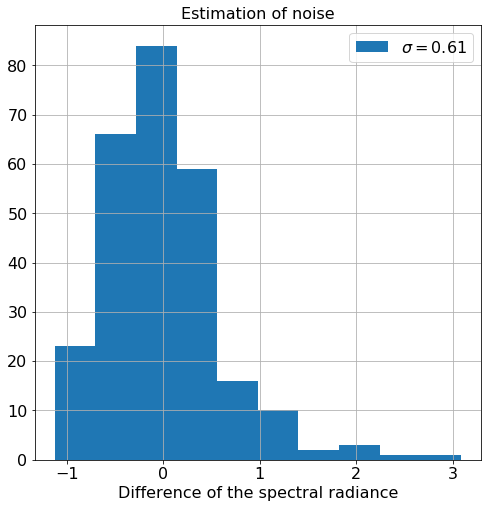

<Figure size 432x288 with 0 Axes>

In [141]:
# Show the noise-histogram
plt.figure(figsize=figsizes)
plt.title("Estimation of noise", fontsize=fs)
plt.hist(histogram, label=r"$\sigma = %.2f$" % np.std(histogram))
plt.xlabel("Difference of the spectral radiance", fontsize=fs)
plt.tick_params(labelsize=fs)
plt.grid(True)
plt.legend(fontsize=fs)
plt.show()
plt.close()
plt.clf()

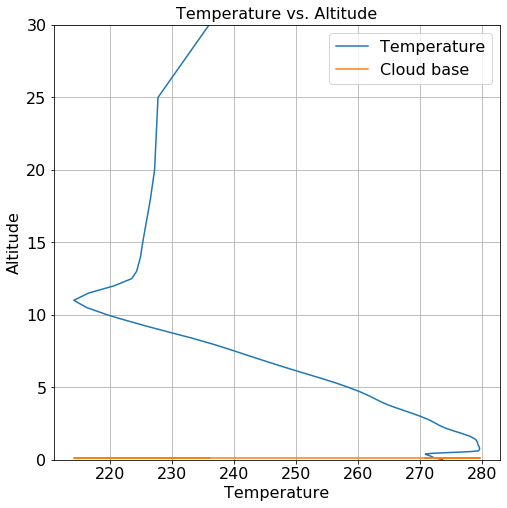

<Figure size 432x288 with 0 Axes>

In [142]:
# Plot the atmospheric profile
plt.figure(figsize=figsizes)
plt.title("Temperature vs. Altitude", fontsize=fs)
plt.plot(temperature, altitude, label="Temperature")
plt.plot(temperature, [cloud_base*1e-3 for ii in range(len(humidity))], label="Cloud base")
plt.xlabel("Temperature", fontsize=fs)
plt.ylabel("Altitude", fontsize=fs)
plt.ylim([0, 30])
plt.grid(True)
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
plt.show()
plt.close()
plt.clf()

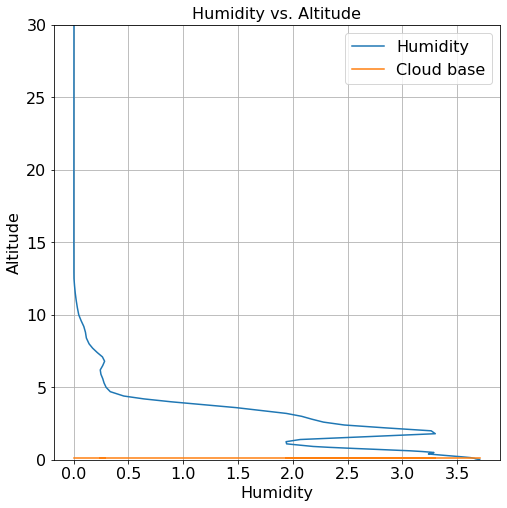

<Figure size 432x288 with 0 Axes>

In [143]:
# Plot the atmospheric profile
plt.figure(figsize=figsizes)
plt.title("Humidity vs. Altitude", fontsize=fs)
plt.plot(humidity, altitude, label="Humidity")
plt.plot(humidity, [cloud_base*1e-3 for ii in range(len(humidity))], label="Cloud base")
plt.xlabel("Humidity", fontsize=fs)
plt.ylabel("Altitude", fontsize=fs)
plt.ylim([0, 30])
plt.grid(True)
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
plt.show()
plt.close()
plt.clf()

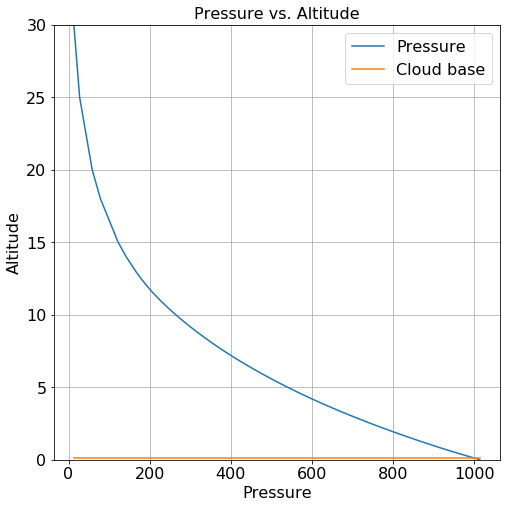

<Figure size 432x288 with 0 Axes>

In [144]:
# Plot the atmospheric profile
plt.figure(figsize=figsizes)
plt.title("Pressure vs. Altitude", fontsize=fs)
plt.plot(pressure, altitude, label="Pressure")
plt.plot(pressure, [cloud_base*1e-3 for ii in range(len(humidity))], label="Cloud base")
plt.xlabel("Pressure", fontsize=fs)
plt.ylabel("Altitude", fontsize=fs)
plt.ylim([0, 30])
plt.grid(True)
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
plt.show()
plt.close()
plt.clf()

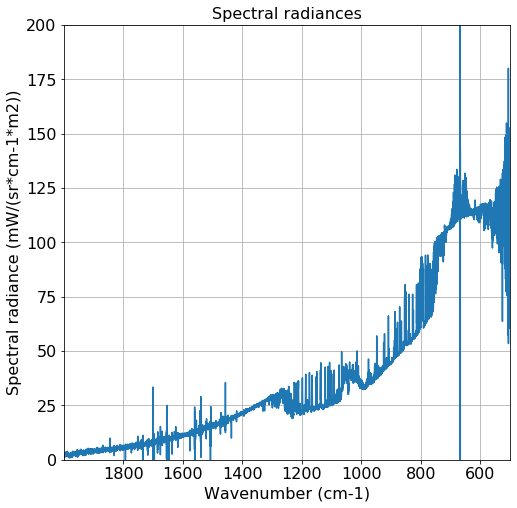

<Figure size 432x288 with 0 Axes>

In [145]:
# Plot the spectral radiances
plt.figure(figsize=figsizes)
plt.title("Spectral radiances", fontsize=fs)
plt.plot(wavenumber, radiance)
plt.xlabel("Wavenumber (cm-1)", fontsize=fs)
plt.ylabel("Spectral radiance (mW/(sr*cm-1*m2))", fontsize=fs)
plt.grid(True)
plt.ylim([0, 200])
plt.xlim([max(wavenumber), min(wavenumber)])
plt.tick_params(labelsize=fs)
plt.show()
plt.close()
plt.clf()

In [146]:
# Working directory
path = "demo"

# Create working directory
if not os.path.exists(path):
    os.mkdir(path)
if not os.path.exists("{}/lblout".format(path)):
    os.mkdir("{}/lblout".format(path))

In [147]:
# Find the altitude layers nearest to the cloud
altitude_cloud_base = list(np.abs(np.array(altitude)-cloud_base*1e-3))
altitude_cloud_top  = list(np.abs(np.array(altitude)-cloud_top*1e-3))
idx_cb = altitude_cloud_base.index(np.min(altitude_cloud_base))
idx_ct = altitude_cloud_top.index(np.min(altitude_cloud_top))
indices = np.arange(idx_cb, idx_ct+1, 1)
cloud_grid = np.array(altitude[indices]*1e3)
cloud_temp = np.mean(temperature[indices])

In [148]:
# Inspect the output
print(cloud_grid, cloud_temp)

[150.] 272.21440112889985


In [149]:
# State vector
mcp     = [1., 1., 10., 30.]

# A Priori
mcp_apr = mcp

# Variance of the a priori
variance_apr = np.identity(4) * np.reciprocal(np.array([5., 5., 100., 100.])**2)

# Calculate the variance matrix of the spectral radiacnes
variance_radiances = np.identity(len(wavenumber)) * np.reciprocal(noise)

In [150]:
# Inspect the output
print("Initial state vector")
print(mcp)
print("A priori")
print(mcp_apr)
print("Variance of the A Priori")
print(variance_apr)
print("Variance of the radiances")
print(variance_radiances)

Initial state vector
[1.0, 1.0, 10.0, 30.0]
A priori
[1.0, 1.0, 10.0, 30.0]
Variance of the A Priori
[[0.04   0.     0.     0.    ]
 [0.     0.04   0.     0.    ]
 [0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.0001]]
Variance of the radiances
[[1.65062001 0.         0.         ... 0.         0.         0.        ]
 [0.         1.65062001 0.         ... 0.         0.         0.        ]
 [0.         0.         1.65062001 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.65062001 0.         0.        ]
 [0.         0.         0.         ... 0.         1.65062001 0.        ]
 [0.         0.         0.         ... 0.         0.         1.65062001]]


In [151]:
# Set up the transfer matrix. This matrix is used to calculate the averaging kernel matrix
t_matrix = [np.zeros((4, len(wavenumber)))]

# Levenberg-Marquardt parameter
lm = 1e4

# Covariance matrix of the retrieval (wildcard)
cov_matrix = None

# From now, the iteration loop starts. You can rerun the next cells to perform the iteration. After each iteration, the convergence criterion can be checked